In [ ]:
# Packages
import pandas as pd
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import re
import string
import nltk
# Initialize NLTK resources
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# TF-IDF Vectorization

In [ ]:
# Load the data
data_q = pd.read_csv("/content/drive/MyDrive/ML assignments/Assig_4_data.csv")

# Define stopwords and lemmatizer
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# Extend the list of stopwords to exclude question words
question_words = ['what', 'when', 'where', 'which', 'who', 'whom', 'why', 'how']
for word in question_words:
    stop_words.remove(word)


def preprocess_text_kq(text):
    text = text.lower()
    text = re.sub(r'\d+', '', text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = re.sub(' +', ' ', text)

    # Tokenization, Lemmatization, and removal of stopwords
    tokens = word_tokenize(text)
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]

    # Add back question words
    tokens = [word for word in tokens if word in question_words or word not in stop_words]

    return ' '.join(tokens)

# Apply preprocessing
data_q['cleaned_text'] = data_q['sentence'].apply(preprocess_text_kq)
data_q["label"] = (data_q["label"] == "question").astype(int)

# Drop unnecessary columns
data_q = data_q.drop('sentence', axis=1)
data_q = data_q.drop('Unnamed: 0', axis=1)

**Splitting the dataset**

In [ ]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(data_q['cleaned_text'], data_q['label'], test_size=0.2, random_state=42)

In [ ]:
# TF-IDF Vectorization
tfidf_vectorizer = TfidfVectorizer(max_features=100)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)
X_test_tfidf.shape

(47022, 100)

In [ ]:
# Logistic Regression
lr_best = LogisticRegression(max_iter=1000, solver='saga')
lr_best.fit(X_train_tfidf, y_train)
lr_pred = lr_best.predict_proba(X_test_tfidf)[:, 1]
print(f"Logistic Regression ROC AUC: {roc_auc_score(y_test, lr_pred)}")

Logistic Regression ROC AUC: 0.9712357519836365


In [ ]:
# Naive Bayes
nb = MultinomialNB(alpha=0.5)
nb.fit(X_train_tfidf, y_train)
nb_pred = nb.predict_proba(X_test_tfidf)[:, 1]
print(f"Naive Bayes ROC AUC: {roc_auc_score(y_test, nb_pred)}")

Naive Bayes ROC AUC: 0.9261844936414123


In [ ]:
# Random Forest
rf = RandomForestClassifier(n_estimators=100,max_depth=10)
rf.fit(X_train_tfidf, y_train)
rf_pred = rf.predict_proba(X_test_tfidf)[:, 1]
print(f"Random Forest ROC AUC: {roc_auc_score(y_test, rf_pred)}")

Random Forest ROC AUC: 0.9706538065230552


In [ ]:
# Decision Tree
dt = DecisionTreeClassifier(max_depth=10)
dt.fit(X_train_tfidf, y_train)
dt_pred = dt.predict_proba(X_test_tfidf)[:, 1]
print(f"Decision Tree ROC AUC: {roc_auc_score(y_test, dt_pred)}")

Decision Tree ROC AUC: 0.9697552492954871


In [ ]:
# Convert scaled arrays back to lists of strings
X_train_text = [' '.join(map(str, row)) for row in X_train_tfidf]
X_test_text = [' '.join(map(str, row)) for row in X_test_tfidf]
tokenizer = Tokenizer(num_words=5000)
# Tokenization
tokenizer.fit_on_texts(X_train_text)

X_train_seq = tokenizer.texts_to_sequences(X_train_text)
X_test_seq = tokenizer.texts_to_sequences(X_test_text)
# LSTM
X_train_pad = pad_sequences(X_train_seq, maxlen=100)
X_test_pad = pad_sequences(X_test_seq, maxlen=100)

lstm = Sequential([
    Embedding(5000, 32, input_length=100),
    LSTM(32),
    Dense(1, activation='sigmoid') #with sigmoid activation function
])

lstm.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
lstm.fit(X_train_pad, y_train, epochs=5, batch_size=128, verbose=1)
lstm_pred = lstm.predict(X_test_pad).ravel()
lstm_pred = np.where(lstm_pred > 0.5, 1, 0)
print(f"LSTM ROC AUC: {roc_auc_score(y_test, lstm_pred)}")

Epoch 1/5
1470/1470 [==============================] - 142s 95ms/step - loss: 0.2138 - accuracy: 0.9198
Epoch 2/5
1470/1470 [==============================] - 128s 87ms/step - loss: 0.1765 - accuracy: 0.9371
Epoch 3/5
1470/1470 [==============================] - 136s 93ms/step - loss: 0.1742 - accuracy: 0.9372
Epoch 4/5
1470/1470 [==============================] - 140s 95ms/step - loss: 0.1730 - accuracy: 0.9380
Epoch 5/5
1470/1470 [==============================] - 18s 12ms/step
LSTM ROC AUC: 0.93119565192949


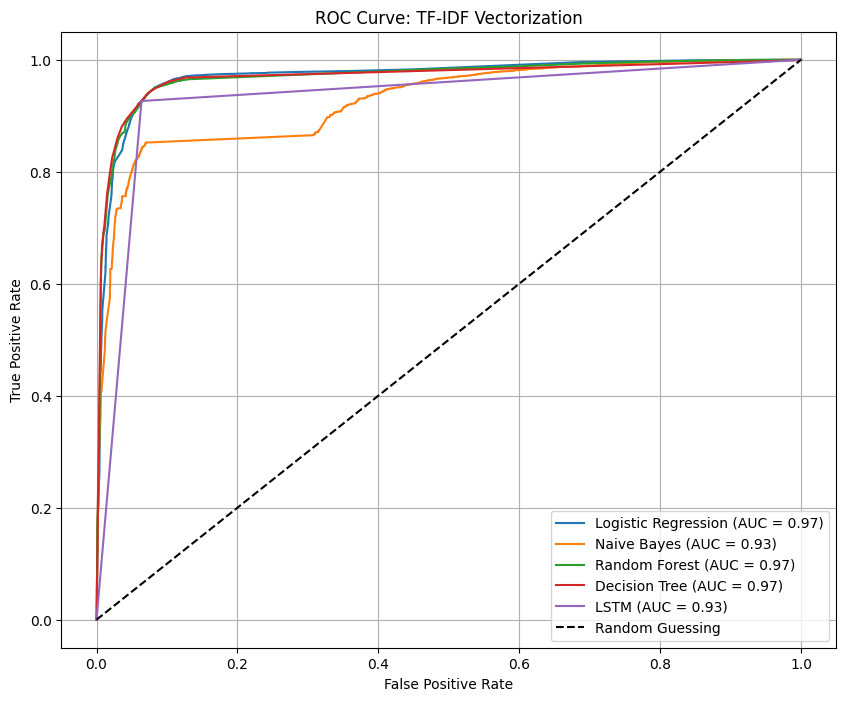

In [ ]:
#plotting
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_pred)
lr_auc = roc_auc_score(y_test, lr_pred)

nb_fpr, nb_tpr, _ = roc_curve(y_test, nb_pred)
nb_auc = roc_auc_score(y_test, nb_pred)

rf_fpr, rf_tpr, _ = roc_curve(y_test, rf_pred)
rf_auc = roc_auc_score(y_test, rf_pred)

dt_fpr, dt_tpr, _ = roc_curve(y_test, dt_pred)
dt_auc = roc_auc_score(y_test, dt_pred)

lstm_fpr, lstm_tpr, _ = roc_curve(y_test, lstm_pred)
lstm_auc = roc_auc_score(y_test, lstm_pred)

# Plot ROC curves
plt.figure(figsize=(10, 8))


plt.plot(lr_fpr, lr_tpr, label=f'Logistic Regression (AUC = {lr_auc:.2f})')
plt.plot(nb_fpr, nb_tpr, label=f'Naive Bayes (AUC = {nb_auc:.2f})')
plt.plot(rf_fpr, rf_tpr, label=f'Random Forest (AUC = {rf_auc:.2f})')
plt.plot(dt_fpr, dt_tpr, label=f'Decision Tree (AUC = {dt_auc:.2f})')
plt.plot(lstm_fpr, lstm_tpr, label=f'LSTM (AUC = {lstm_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='black', label='Random Guessing')


plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve: TF-IDF Vectorization')
plt.legend()
plt.grid(True)
plt.show()

#LSA Vextorizer

In [ ]:
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import MinMaxScaler

In [ ]:
# LSA Vectorization
lsa_vectorizer = TruncatedSVD(n_components=100)
X_train_lsa = lsa_vectorizer.fit_transform(X_train_tfidf)
X_test_lsa = lsa_vectorizer.transform(X_test_tfidf)

In [ ]:
# MinMaxScaler
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train_lsa)
X_test_scaled = scaler.transform(X_test_lsa)

In [ ]:
# Logistic Regression
lr = LogisticRegression(max_iter=1000, solver='saga')
lr.fit(X_train_lsa, y_train)
lr_pred = lr.predict_proba(X_test_lsa)[:, 1]
print(f"Logistic Regression ROC AUC: {roc_auc_score(y_test, lr_pred)}")

# Naive Bayes
# Data scaled with Minmax scaler
nb = MultinomialNB()
nb.fit(X_train_scaled, y_train)
nb_pred = nb.predict_proba(X_test_scaled)[:, 1]
print(f"Naive Bayes ROC AUC: {roc_auc_score(y_test, nb_pred)}")

Logistic Regression ROC AUC: 0.9712312472513233
Naive Bayes ROC AUC: 0.9519726862133248


In [ ]:
# Random Forest
rf = RandomForestClassifier(n_estimators=100,max_depth=10)
rf.fit(X_train_lsa, y_train)
rf_pred = rf.predict_proba(X_test_lsa)[:, 1]
print(f"Random Forest ROC AUC: {roc_auc_score(y_test, rf_pred)}")

Random Forest ROC AUC: 0.971318496126643


In [ ]:
# Decision Tree
dt = DecisionTreeClassifier(max_depth=10)
dt.fit(X_train_lsa, y_train)
dt_pred = dt.predict_proba(X_test_lsa)[:, 1]
print(f"Decision Tree ROC AUC: {roc_auc_score(y_test, dt_pred)}")

Decision Tree ROC AUC: 0.9702787958252344


In [ ]:
# Convert scaled arrays back to lists of strings
X_train_text = [' '.join(map(str, row)) for row in X_train_lsa]
X_test_text = [' '.join(map(str, row)) for row in X_test_lsa]
tokenizer = Tokenizer(num_words=5000)
# Tokenization
tokenizer.fit_on_texts(X_train_text)

X_train_seq = tokenizer.texts_to_sequences(X_train_text)
X_test_seq = tokenizer.texts_to_sequences(X_test_text)
# LSTM
X_train_pad = pad_sequences(X_train_seq, maxlen=100)
X_test_pad = pad_sequences(X_test_seq, maxlen=100)

lstm = Sequential([
    Embedding(5000, 32),
    LSTM(32),
    Dense(1, activation='sigmoid')
])

lstm.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
lstm.fit(X_train_pad, y_train, epochs=5, batch_size=256, verbose=1)
lstm_pred = lstm.predict(X_test_pad).ravel()
lstm_pred = np.where(lstm_pred > 0.5, 1, 0)
print(f"LSTM ROC AUC: {roc_auc_score(y_test, lstm_pred)}")


Epoch 1/5
735/735 [==============================] - 70s 93ms/step - loss: 0.4787 - accuracy: 0.7369
Epoch 2/5
735/735 [==============================] - 68s 93ms/step - loss: 0.4599 - accuracy: 0.7526
Epoch 3/5
735/735 [==============================] - 70s 95ms/step - loss: 0.4594 - accuracy: 0.7534
Epoch 4/5
735/735 [==============================] - 91s 124ms/step - loss: 0.4564 - accuracy: 0.7554
Epoch 5/5
1470/1470 [==============================] - 28s 18ms/step
LSTM ROC AUC: 0.7669772484856934


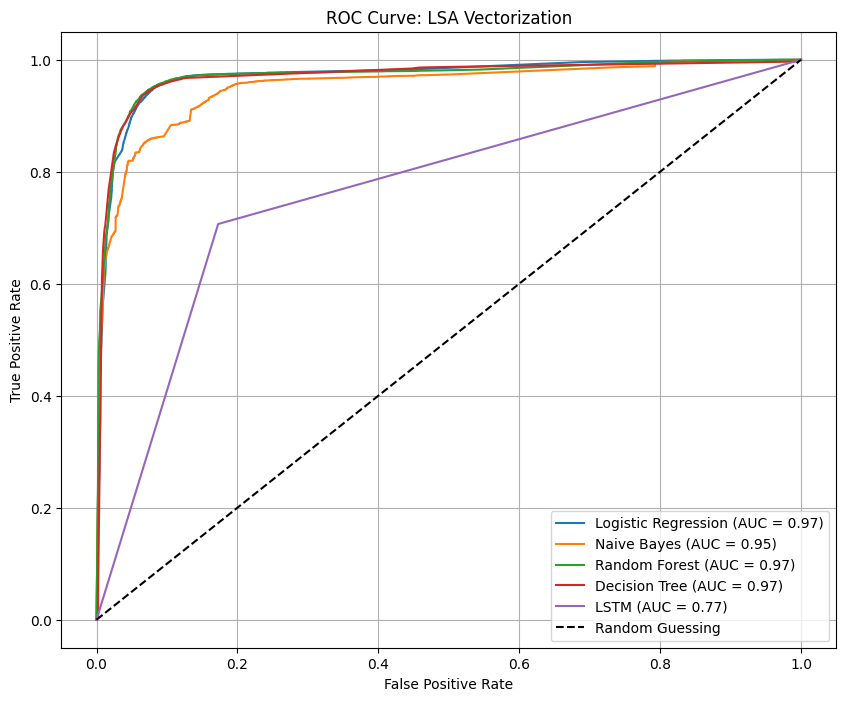

In [ ]:
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_pred)
lr_auc = roc_auc_score(y_test, lr_pred)

nb_fpr, nb_tpr, _ = roc_curve(y_test, nb_pred)
nb_auc = roc_auc_score(y_test, nb_pred)

rf_fpr, rf_tpr, _ = roc_curve(y_test, rf_pred)
rf_auc = roc_auc_score(y_test, rf_pred)

dt_fpr, dt_tpr, _ = roc_curve(y_test, dt_pred)
dt_auc = roc_auc_score(y_test, dt_pred)

lstm_fpr, lstm_tpr, _ = roc_curve(y_test, lstm_pred)
lstm_auc = roc_auc_score(y_test, lstm_pred)

# Plot ROC curves
plt.figure(figsize=(10, 8))


plt.plot(lr_fpr, lr_tpr, label=f'Logistic Regression (AUC = {lr_auc:.2f})')
plt.plot(nb_fpr, nb_tpr, label=f'Naive Bayes (AUC = {nb_auc:.2f})')
plt.plot(rf_fpr, rf_tpr, label=f'Random Forest (AUC = {rf_auc:.2f})')
plt.plot(dt_fpr, dt_tpr, label=f'Decision Tree (AUC = {dt_auc:.2f})')
plt.plot(lstm_fpr, lstm_tpr, label=f'LSTM (AUC = {lstm_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='black', label='Random Guessing')


plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve: LSA Vectorization')
plt.legend()
plt.grid(True)
plt.show()

#LDA Vectorizer

In [ ]:
from sklearn.decomposition import LatentDirichletAllocation

In [ ]:
# LDA
lda = LatentDirichletAllocation(n_components=10, random_state=42, max_iter=10)
X_train_lda = lda.fit_transform(X_train_tfidf)
X_test_lda = lda.transform(X_test_tfidf)


In [ ]:
# Logistic Regression
lr = LogisticRegression(max_iter=1000, solver='saga')
lr.fit(X_train_lda, y_train)
lr_pred = lr.predict_proba(X_test_lda)[:, 1]
print(f"Logistic Regression ROC AUC: {roc_auc_score(y_test, lr_pred)}")
# Naive Bayes
nb = MultinomialNB()
nb.fit(X_train_lda, y_train)
nb_pred = nb.predict_proba(X_test_lda)[:, 1]
print(f"Naive Bayes ROC AUC: {roc_auc_score(y_test, nb_pred)}")

Logistic Regression ROC AUC: 0.7018748322942541
Naive Bayes ROC AUC: 0.6942410590874053


In [ ]:
# Random Forest
rf = RandomForestClassifier(n_estimators=100,max_depth=10)
rf.fit(X_train_lda, y_train)
rf_pred = rf.predict_proba(X_test_lda)[:, 1]
print(f"Random Forest ROC AUC: {roc_auc_score(y_test, rf_pred)}")

Random Forest ROC AUC: 0.9501549890630538


In [ ]:
# Decision Tree
dt = DecisionTreeClassifier(max_depth=10)
dt.fit(X_train_lda, y_train)
dt_pred = dt.predict_proba(X_test_lda)[:, 1]
print(f"Decision Tree ROC AUC: {roc_auc_score(y_test, dt_pred)}")

Decision Tree ROC AUC: 0.939414904386726


In [ ]:
from keras.layers import concatenate
from sklearn.preprocessing import StandardScaler

# LSTM
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)
X_train_pad = pad_sequences(X_train_seq, maxlen=100)
X_test_pad = pad_sequences(X_test_seq, maxlen=100)

# Standardize LDA values
scaler = StandardScaler()
X_train_lda_scaled = scaler.fit_transform(X_train_lda)
X_test_lda_scaled = scaler.transform(X_test_lda)

# Concatenate LSTM input
X_train_combined = np.concatenate((X_train_pad, X_train_lda_scaled[:, :10]), axis=1)
X_test_combined = np.concatenate((X_test_pad, X_test_lda_scaled[:, :10]), axis=1)

lstm = Sequential([
    Embedding(5000, 32),
    LSTM(32),
    Dense(64, activation='relu'),  # Add a dense layer for combined features
    Dense(1, activation='sigmoid')
])

lstm.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
lstm.fit(X_train_combined, y_train, epochs=5, batch_size=128, verbose=1)
lstm_pred = lstm.predict(X_test_combined).ravel()
lstm_pred = np.where(lstm_pred > 0.5, 1, 0)
print(f"LSTM ROC AUC: {roc_auc_score(y_test, lstm_pred)}")

Epoch 1/5
1470/1470 [==============================] - 130s 87ms/step - loss: 0.1447 - accuracy: 0.9438
Epoch 2/5
1470/1470 [==============================] - 127s 86ms/step - loss: 0.0734 - accuracy: 0.9763
Epoch 3/5
1470/1470 [==============================] - 124s 84ms/step - loss: 0.0615 - accuracy: 0.9803
Epoch 4/5
1470/1470 [==============================] - 172s 117ms/step - loss: 0.0519 - accuracy: 0.9831
Epoch 5/5
1470/1470 [==============================] - 25s 17ms/step
LSTM ROC AUC: 0.9764151579818441


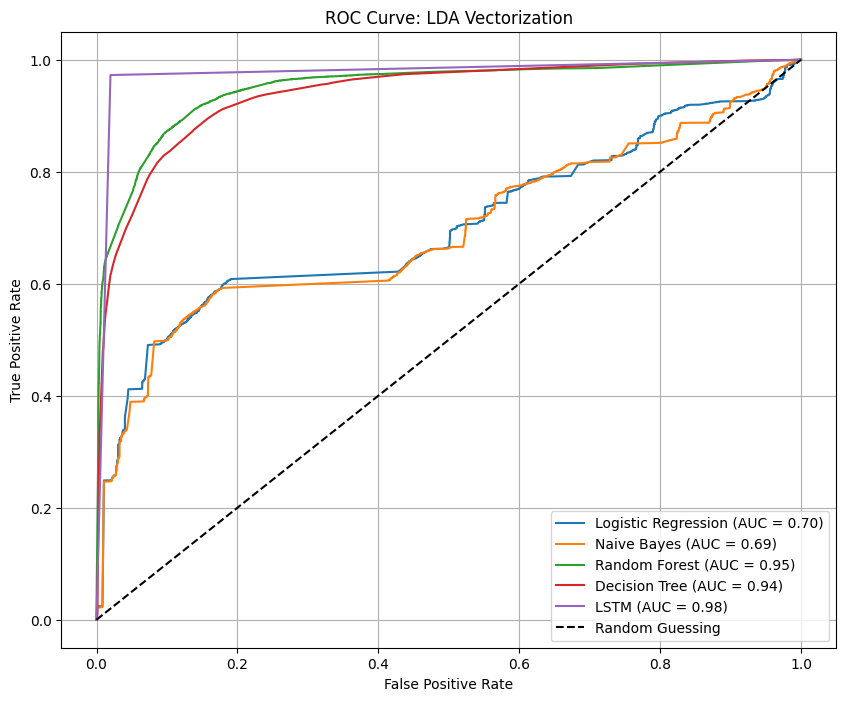

In [ ]:
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_pred)
lr_auc = roc_auc_score(y_test, lr_pred)

nb_fpr, nb_tpr, _ = roc_curve(y_test, nb_pred)
nb_auc = roc_auc_score(y_test, nb_pred)

rf_fpr, rf_tpr, _ = roc_curve(y_test, rf_pred)
rf_auc = roc_auc_score(y_test, rf_pred)

dt_fpr, dt_tpr, _ = roc_curve(y_test, dt_pred)
dt_auc = roc_auc_score(y_test, dt_pred)

lstm_fpr, lstm_tpr, _ = roc_curve(y_test, lstm_pred)
lstm_auc = roc_auc_score(y_test, lstm_pred)

# Plot ROC curves
plt.figure(figsize=(10, 8))


plt.plot(lr_fpr, lr_tpr, label=f'Logistic Regression (AUC = {lr_auc:.2f})')
plt.plot(nb_fpr, nb_tpr, label=f'Naive Bayes (AUC = {nb_auc:.2f})')
plt.plot(rf_fpr, rf_tpr, label=f'Random Forest (AUC = {rf_auc:.2f})')
plt.plot(dt_fpr, dt_tpr, label=f'Decision Tree (AUC = {dt_auc:.2f})')
plt.plot(lstm_fpr, lstm_tpr, label=f'LSTM (AUC = {lstm_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='black', label='Random Guessing')


plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve: LDA Vectorization')
plt.legend()
plt.grid(True)
plt.show()